# HOW IS GENDER DISTRIBUTED ON EPFL CAMPUS AND CAN WE PREDICT IT ?
NTDS 2019 project main file
* Team: 1
* Students: Magnin Jonathan, Nonaca Darja, Shmeis Zeinab, Wang Shu

## LICENSE
### YOLO LICENSE
Version 2, July 29 2016

THIS SOFTWARE LICENSE IS PROVIDED "ALL CAPS" SO THAT YOU KNOW IT IS SUPER
SERIOUS AND YOU DON'T MESS AROUND WITH COPYRIGHT LAW BECAUSE YOU WILL GET IN
TROUBLE HERE ARE SOME OTHER BUZZWORDS COMMONLY IN THESE THINGS WARRANTIES
LIABILITY CONTRACT TORT LIABLE CLAIMS RESTRICTION MERCHANTABILITY. NOW HERE'S
THE REAL LICENSE:

0. Darknet is public domain.
1. Do whatever you want with it.
2. Stop emailing me about it!

## DESCRIPTION
This notebook contains all the code of our project. It is structured in the following way :

* Data Aquisition and Formatting
* Data Processing
* Data Exploration
    * Dimensionality reduction
    * Graph creation and visualization
* Prediction


## 0. Packages

In [1]:
# packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
from sklearn.linear_model import LogisticRegression
from mpl_toolkits.mplot3d import Axes3D
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import networkx as nx
from scipy.spatial.distance import pdist, squareform

## 1. Data Aquisition and Formatting
Most of the data aquisition is done in the create_dataset.ipynb file, that cannot be executed because private data are not uploaded.
The result of this code is in the Dataset folder, we simply load it.

In [2]:
# load dataset
complete_data = pd.read_csv("../Dataset/complete_data.csv")
complete_test_data = pd.read_csv("../Dataset/complete_test_data.csv")

# have a look at the data
complete_data

,Unnamed: 0,course,course_sct,prof,sct_student,year,gender,nationality,student_id
0,0,1st Workshop on Advances in CFD and MD modelli...,Energie (edoc),"Thome John Richard, Magnini Mirco, Various lec...","Mécanique (edoc), EDOC",2016-2017,Monsieur,suisse,27667
1,1,Similarity and Transport Phenomena in Fluid,Mécanique (edoc),Ancey Christophe,"Mécanique (edoc), EDOC",2016-2017,Monsieur,suisse,27667
2,4,1st Workshop on Advances in CFD and MD modelli...,Energie (edoc),"Thome John Richard, Magnini Mirco, Various lec...","Energie (edoc), EDOC",2016-2017,Monsieur,allemande,46270
3,6,"2D Layered Materials: Synthesis, Properties an...",Science et génie des matériaux (edoc),Kis Andras,"Auditeurs EDOC, 2016-2017",2016-2017,Monsieur,suisse,21602
4,8,"2D Layered Materials: Synthesis, Properties an...",Science et génie des matériaux (edoc),Kis Andras,"Physique (edoc), EDOC",2016-2017,Monsieur,française,48264
...,...,...,...,...,...,...,...,...,...
227482,229274,Théorie et critique du projet MA1 (Födinger),Mobilité AR,Födinger Karsten,NaN,"2019-2020, Semestre automne",Monsieur,allemande,67309
227483,229275,UE A: Art and architecture,Mobilité AR,Weber Christoph,NaN,"2019-2020, Semestre automne",Monsieur,allemande,67309
227484,229276,Théorie et critique du projet MA1 (Weinand),Mobilité AR,Weinand Yves,NaN,"2019-2020, Semestre automne",Madame,allemande,67287
227485,229277,UE K : Architecture et durabilité : études de ...,Mobilité AR,"Rey Emmanuel, Fivet Corentin Jean Dominique, F...",NaN,"2019-2020, Semestre automne",Madame,allemande,67287


## 2. Data Processing

### 2.1 Sorting
The goal of this section is to extract the features, which are the courses that each students subscribes to.
In these data, we do not want to use everything.
We work with master students and courses because includoing bachelor students has three problems :

* It lower the prediction accuracy due to the large amount of common courses
* It deteriorates the quality of visualization
* It does not makes much sense to include it since there is no or little choice in bachelor courses and we base our prediction on this choice

Thus, we only use data from master students.

In [3]:
# identify bachelor and master students
year = complete_data['year']
ma =['Master' in s for s in year]
ba = ['Bachelor' in s for s in year]
pd_master = complete_data[ma]
pd_bachelor = complete_data[ba]

In [4]:
print(f"Number of Master students: {len(pd_master['student_id'].unique())}")
print(f"Number of Bachelor students: {len(pd_bachelor['student_id'].unique())}")

Number of Master students: 6530
Number of Bachelor students: 10464


In [5]:
print(f"Number of Master courses: {len(pd_master['course'].unique())}")
print(f"Number of Bachelor courses: {len(pd_bachelor['course'].unique())}")

Number of Master courses: 966
Number of Bachelor courses: 755


In [6]:
course_count = pd_master['course'].value_counts()
course_count

Machine learning                                                    846
Applied data analysis                                               756
Management de projet et analyse du risque                           651
Image processing I                                                  598
Applied machine learning                                            533
                                                                   ... 
Stages semestriels                                                    1
Projet de master en ingénierie financière                             1
Single- and two-phase particulate flows                               1
Projet de master en gestion de l'énergie et construction durable      1
UE I : Analogue-Digital-Virtuel                                       1
Name: course, Length: 966, dtype: int64

In [7]:
#get all student ids and the courses
stud_ids = pd_master["student_id"].unique()
courses = pd_master['course'].unique()
n_stud = len(stud_ids)
n_c = len(courses)

### 2.2 Preparing the features matrix for ML part

In [8]:
# creating the  student_course_matrix
student_course_matrix = np.empty((n_stud, n_c))
for idx, row in pd_master.iterrows():
    l = np.where(row["student_id"] == stud_ids)
    c = np.where(courses == row["course"])
    student_course_matrix[l[0][0]][c[0][0]] = 1

Here we prepare the test data to be used in the machine learning part. These data are from 2015-2016 and we need to treat them as in the previous block (we remove the bachelor students).

In [9]:
# isolate master students 
year = complete_test_data['year']
ma =['Master' in s for s in year]
pd_master_test = complete_test_data[ma]
stud_ids_test = pd_master_test["student_id"].unique()
courses = pd_master_test['course'].unique()

n_stud = stud_ids_test.shape[0]
n_c = courses.shape[0]
student_course_matrix_test = np.empty((n_stud, n_c))
for idx, row in pd_master_test.iterrows():
    l = np.where(row["student_id"] == stud_ids_test)
    c = np.where(courses == row["course"])
    student_course_matrix_test[l[0][0]][c[0][0]] = 1

Finaly, let us have a look at the feature matrices :

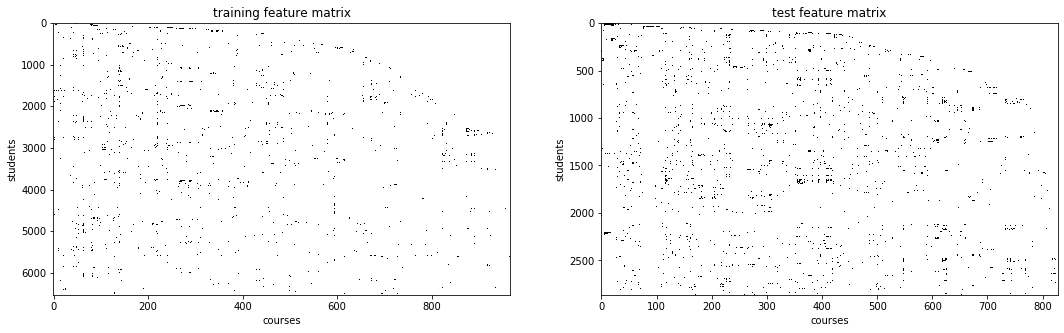

In [10]:
# plot feature matrices

fig = plt.figure(figsize=(18,5))
fig1 = plt.gcf()
plt.subplot(121)
plt.xlabel('courses')
plt.ylabel('students')
plt.title('training feature matrix')
plt.imshow(student_course_matrix, aspect='auto', cmap='binary')

plt.subplot(122)
plt.xlabel('courses')
plt.ylabel('students')
plt.title('test feature matrix')
plt.imshow(student_course_matrix_test, aspect='auto', cmap='binary')

plt.show()
fig1.savefig('../Images/student_course_matrix.png')

**Labeling for ML**
The goal of this section is to create labels for prediction. We will use the following labels :
* Sections
* Faculties
* Gender

In [11]:
# section labels for training data
sections = pd_master['sct_student'].unique()
new_sections = np.ndarray(0)

# remove unwanted info (year/semester)
for line in sections :
    if type(line) is str :
        new_line = line.split(",")[0]
        new_sections = np.append(new_sections, new_line)

# create the section list with an "other" section for undefined fields of the dataset
new_sections = np.append(new_sections, ["other"])
sections = np.unique(new_sections)
print("All sections :")
for i,s in enumerate(sections) :
    print((str)(i) + " : " + s)
    
# create (numeric) labels, the labels will be the index of the section in the array above
students_sct_label = np.ndarray(stud_ids.shape)
for i in range(0,stud_ids.shape[0]) :
    # get section of student
    id = stud_ids[i]
    sct = complete_data.loc[complete_data["student_id"] == id, "sct_student"] # will return EVERY entry of student's section : can sometimes be NaN !!!
    for elem in sct :
        if type(elem) is str :
            sct = elem
            break
    
    # if there are only NaN
    if type(sct) is not str :
        sct = "other"
    
    # find the good label
    for j in range(0, sections.shape[0]) :
        if (sct.find(sections[j]) != -1) :
            students_sct_label[i] = (int)(j)
            break

# gender labels for training data
students_gender = list()
for i in range(0, stud_ids.shape[0]) :
    id = stud_ids[i]
    gender = (str)(complete_data.loc[complete_data["student_id"] == id, "gender"])
    if gender.find("Monsieur") != -1 :
        gender = 1
    else :
        gender = 0
    students_gender.append(gender)

# gender labels for test data
students_gender_test = list()
for i in range(0, stud_ids_test.shape[0]) :
    id = stud_ids_test[i]
    gender = (str)(complete_test_data.loc[complete_test_data["student_id"] == id, "gender"])
    if gender.find("Monsieur") != -1 :
        gender = 1
    else :
        gender = 0
    students_gender_test.append(gender)

All sections :
0 : Approches moléculaires du vivant (edoc)
1 : Architecture
2 : Architecture et sciences de la ville (edoc)
3 : Auditeurs libres
4 : Bioingénierie
5 : Biologie computationnelle et quantitative (edoc)
6 : Biotechnologie et génie biologique (edoc)
7 : Chimie et génie chimique
8 : Chimie et génie chimique (edoc)
9 : Chimie moléculaire et biologique
10 : Data Science
11 : Energie (edoc)
12 : Energy Science and Technology
13 : Gestion de l'énergie et durabilité
14 : Génie chimique et biotechnologie
15 : Génie civil
16 : Génie civil et environnement (edoc)
17 : Génie mécanique
18 : Génie nucléaire
19 : Génie électrique (edoc)
20 : Génie électrique et électronique 
21 : Humanités digitales
22 : Informatique
23 : Informatique - Cybersecurity
24 : Informatique et communications (edoc)
25 : Ingénierie des sciences du vivant
26 : Ingénierie financière
27 : Ingénierie mathématique
28 : Ingénierie physique
29 : Management
30 : Management de la technologie (edoc)
31 : Manufacturing (

We can see that there are many, many sections. This is mostly due to exchanges, external students, "auditeurs libres",... Thus, to have less labels, we use the "real" sections, for instance, an exchange student in EL is indeed in the EL section. We also regroup the sections in their faculties to have an even smaller amount of labels, but this might be slightly gross.

In [12]:
# create an array that makes sections correspond to faculties
sct_to_fac = list()

for i in range(0, sections.shape[0]) :
    sct_to_fac.append("")

sct_to_fac[0] = "SV"
sct_to_fac[1] = "ENAC"
sct_to_fac[2] = "ENAC"
sct_to_fac[3] = "other"
sct_to_fac[4] = "STI"
sct_to_fac[5] = "SV"
sct_to_fac[6] = "SV"
sct_to_fac[7] = "SB"
sct_to_fac[8] = "SB"
sct_to_fac[9] = "SB"
sct_to_fac[10] = "IC"
sct_to_fac[11] = "STI"
sct_to_fac[12] = "STI"
sct_to_fac[13] = "STI"
sct_to_fac[14] = "SB"
sct_to_fac[15] = "ENAC"
sct_to_fac[16] = "ENAC"
sct_to_fac[17] = "STI"
sct_to_fac[18] = "SB"
sct_to_fac[19] = "STI"
sct_to_fac[20] = "STI"
sct_to_fac[21] = "CDH"
sct_to_fac[22] = "IC"
sct_to_fac[23] = "IC"
sct_to_fac[24] = "IC"
sct_to_fac[25] = "SV"
sct_to_fac[26] = "CDM"
sct_to_fac[27] = "SB"
sct_to_fac[28] = "SB"
sct_to_fac[29] = "CDM"
sct_to_fac[30] = "CDM"
sct_to_fac[31] = "STI"
sct_to_fac[32] = "SB"
sct_to_fac[33] = "SB"
sct_to_fac[34] = "SB"
sct_to_fac[35] = "SB"
sct_to_fac[36] = "STI"
sct_to_fac[37] = "STI"
sct_to_fac[38] = "STI"
sct_to_fac[39] = "ENAC"
sct_to_fac[40] = "SB"
sct_to_fac[41] = "STI"
sct_to_fac[42] = "ENAC"
sct_to_fac[43] = "STI"
sct_to_fac[44] = "CDM"
sct_to_fac[45] = "IC"
sct_to_fac[46] = "SB"
sct_to_fac[47] = "STI"
sct_to_fac[48] = "CDM"
sct_to_fac[49] = "STI"
sct_to_fac[50] = "SB"
sct_to_fac[51] = "IC"
sct_to_fac[52] = "ENAC"
sct_to_fac[53] = "SV"
sct_to_fac[54] = "STI"
sct_to_fac[55] = "SV"
sct_to_fac[56] = "STI"
sct_to_fac[57] = "STI"
sct_to_fac[58] = "SB"
sct_to_fac[59] = "SB"
sct_to_fac[60] = "SB"
sct_to_fac[61] = "STI"
sct_to_fac[62] = "STI"
sct_to_fac[63] = "STI"
sct_to_fac[64] = "SB"
sct_to_fac[65] = "ENAC"
sct_to_fac[66] = "SV"
sct_to_fac[67] = "IC"
sct_to_fac[68] = "other"
sct_to_fac[69] = "other"
sct_to_fac[70] = "other"
sct_to_fac[71] = "other"
sct_to_fac[72] = "other"
# create  alist of all faculties
fac_list = ['ENAC', 'IC', 'SB', 'STI', 'SV', 'CDH', 'CDM', 'other']

In [13]:
# label the students with faculties
students_fac = list()
for i in range(0, stud_ids.shape[0]) :
    id = stud_ids[i]
    fac = sct_to_fac[(int)(students_sct_label[i])]
    students_fac.append(fac)

### 2.3 CLEANING DATA FOR THE GRAPHS CONSTRUCTION

The max number of enrolled students to a class: 846
The avg number of enrolled students to a class: 62.997929606625256
The standard deviation is: 76.48383092673248


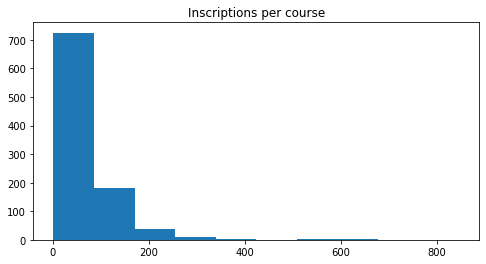

In [14]:
n_insc = pd_master['course'].value_counts().values
max_val =n_insc.max()
print(f"The max number of enrolled students to a class: {max_val}")
mean = n_insc.mean()
print(f"The avg number of enrolled students to a class: {mean}")
std_dev = n_insc.std()
print(f"The standard deviation is: {std_dev}")
plt.figure(1, figsize=(8, 4))
fig2 = plt.gcf()
plt.title("Inscriptions per course")
plt.hist(n_insc, bins = 10);
fig2.savefig('../Images/hist_stud_iscr_course.png')

As we will link students based on the number of classes they have in common, the number of classes that we consider is proportional to the possible number of clusters. For this reason, we decide to remove less popular classes. We think that considering 241 classes is a good starting point, thus we select the 3rd quantile as the "filtering out threshold". 

In [15]:
#plot quantiles
print(f"The 1st quantile is (will select 724.5 classes): {np.quantile(n_insc, 0.25)}")
print(f"The median (will select 483 classes) is: {np.quantile(n_insc, 0.5)}")
q3 = np.quantile(n_insc, 0.75)
print(f"The 3rd quantile (will select 241.5 classes) is: {q3}")

The 1st quantile is (will select 724.5 classes): 18.0
The median (will select 483 classes) is: 38.5
The 3rd quantile (will select 241.5 classes) is: 85.0


In [16]:
#eliminating the courses with less than q3 total enrollements between 2017-2019
all_courses = pd_master['course'].value_counts().to_frame()
courses_to_keep = all_courses.loc[all_courses["course"] > q3].reset_index()
courses_to_keep = courses_to_keep.rename( columns={"index":"course",  "course": "nb_stud"})
courses_to_keep_names = courses_to_keep["course"].values.tolist();
pd_master_filt = pd_master[[pd_master.iloc[i]["course"] in courses_to_keep_names for i in np.arange(pd_master.shape[0])]]
pd_master_filt.shape

(37904, 9)

Creating the "reduced" adjacency matrix:

In [ ]:
stud_ids = pd_master_filt["student_id"].unique()
n_stud = len(stud_ids)
n_c = len(courses_to_keep_names)
##creating the student_course_matrix
student_course_matrix_filt = np.empty((n_stud, n_c))
for idx, row in pd_master_filt.iterrows():
    l = np.where(row["student_id"] == stud_ids)
    c = courses_to_keep_names.index(row["course"])
    student_course_matrix_filt[l[0][0]][c] = 1
    
fig = plt.figure(figsize=(6,5))
fig3 = plt.gcf()
plt.xlabel('courses')
plt.ylabel('students')
plt.title('reduced features matrix')
plt.imshow(student_course_matrix_filt, aspect='auto', cmap='binary')

plt.show()
fig3.savefig('../Images/reduced_stud_course_matrix.png')

**Creating labels for graph clustering**

In [ ]:
import warnings
warnings.filterwarnings('ignore')
section = []
for row in pd_master_filt["sct_student"]:
    if type(row) is not float:
        section.append(row.split(",")[0])
    else:
        section.append("other")
    
pd_master_filt['section'] = section

sections = pd_master_filt['section'].unique()
sections = sections.tolist()

sections_dict = {
'Génie électrique et électronique ': 'EL',
'Robotique': 'MT',
'Informatique et communications (edoc)': 'IC',
'Mobilité EL': 'EL',
'Management': 'MTE',
'Génie électrique (edoc)': 'EL',
'Ingénierie financière': 'Ingénierie financière',
'Mobilité SV': 'SV',
'Génie mécanique': 'GM',
'Informatique': 'IN',
'Systèmes de communication - master': 'IC',
'Mathématiques - master': 'MA',
'Génie civil et environnement (edoc)': 'GC',
'other': 'other',
'Ingénierie physique': 'PH',
'Micro- and Nanotechnologies for Integrated Systems': 'EL',
'Bioingénierie' : 'SV',
'Physique - master' : 'PH',
'Sciences et technologies du vivant - master': 'SV',
'Génie civil': 'GC',
'Mobilité GC': 'GC',
'Physique - master': 'PH',
'Mobilité CGC': 'CGC',
'Mobilité SC':  'IC',
'Mobilité GM':  'GM',
'Mobilité MTE': 'MTE' ,
'Informatique - Cybersecurity': 'IN',
'Ingénierie mathématique': 'MA',
'Ingénierie des sciences du vivant':'SV',
'Mobilité IN':'IN',
'Science et ingénierie computationnelles':'IC',
'Ingénierie mathématique':'MA',
'Photonique (edoc)':'EL',
'Mathématiques (edoc)': 'MA',
'Chimie moléculaire et biologique': 'CGC',
'Energy Science and Technology':'Energie',
'Ingénierie des sciences du vivant':'SV',
'Génie nucléaire':'Génie nucléaire',
'Auditeurs libres': 'others',
'Mobilité SIE':'SIE',
'UNIL - Sciences forensiques': 'UNIL',
'Microsystèmes et microélectronique (edoc)': 'MT',
'UNIL - HEC': 'UNIL',
'Manufacturing (edoc)': 'others',
'Physique (edoc)': 'PH',
'Mobilité MT': 'MT',
'Management de la technologie (edoc)':'MTE',
'Mobilité AR':'AR',
'Mobilité PH':'PH',
'Biologie computationnelle et quantitative (edoc)':'SV',
'Science et génie des matériaux (edoc)':'MX',
'Approches moléculaires du vivant (edoc)':'SV',
'Energie (edoc)':'Energie',
'Architecture et sciences de la ville (edoc)':'AR',
'Mobilité MX': 'MX',
'Mobilité MA': 'MA',
'Mécanique (edoc)':'GM',
'Biotechnologie et génie biologique (edoc)':'SV',
'UNIL - Géosciences ':'UNIL',
'Chimie et génie chimique (edoc)':'CGC',
'Neurosciences (edoc)':'SV',
'UNIL - Médecine ':'UNIL',
'Passerelle HES - GM':'GM',
'Mobilité IF':'IN',
'Génie chimique et biotechnologie': 'CGC', 
"Sciences et ingénierie de l'environnement": 'SIE',
"Gestion de l'énergie et durabilité": 'Enérgie', 
'Science et génie des matériaux': 'MX', 
'Microtechnique': 'MT', 
'Data Science': 'IC', 
'Humanités digitales': 'Humanités digitales',
'Mathématiques': 'MA', 
'Architecture': 'AR', 
"Mathématiques pour l'enseignement": "Mathématiques pour l'enseignement", 
'Chimie et génie chimique': 'CGC', 
'Physique': 'PH'}

cluster = []
for line in pd_master_filt['section']:
    cluster.append(sections_dict[line])

pd_master_filt['cluster'] = cluster
clusters = pd_master_filt['cluster'].unique()
#dataframe used for labels (made unique on student_id)
pd_labels = pd_master_filt.drop_duplicates(subset = "student_id")
pd_labels = pd_labels[pd_labels.columns[6:11]].reset_index().drop(columns = "index")
pd_labels


In [ ]:
#creating gender labels : 1 if a girl and 0 if a boy
gender_label = [ 1 if row['gender'] == 'Madame' else 0 for idx, row in pd_labels.iterrows() ]
#debug
#np.count_nonzero(np.asarray(gender_label))
#debug
#pd_labels['gender'].value_counts()

## 3. Data Exploration

### 3.1. Dimensionality Reduction
The students live in the "course space", which has a very high dimension and is thus not observable. Dimensionality reduction will allow to observe it. In this section we try different methods and then we will choose the best one:

In [ ]:
dim = 2
# PCA embedding
PCA_embedding = PCA(n_components=dim, copy=True, whiten=True, tol=1e-5)
stu_PCA_2d = PCA_embedding.fit_transform(student_course_matrix_filt)
# ISOMAP
Isomap_embedding = Isomap(n_components=dim,n_neighbors=5)
stu_Isomap_2d = Isomap_embedding.fit_transform(student_course_matrix_filt)
# TSNE
TSNE_embedding = TSNE(n_components=dim)
stu_TSNE_2d = TSNE_embedding.fit_transform(student_course_matrix_filt)

dim = 3
# PCA embedding
PCA_embedding = PCA(n_components=dim, copy=True, whiten=True, tol=1e-5)
stu_PCA_3d = PCA_embedding.fit_transform(student_course_matrix_filt)
# ISOMAP
Isomap_embedding = Isomap(n_components=dim,n_neighbors=5)
stu_Isomap_3d = Isomap_embedding.fit_transform(student_course_matrix_filt)
# TSNE
TSNE_embedding = TSNE(n_components=dim)
stu_TSNE_3d = TSNE_embedding.fit_transform(student_course_matrix_filt)

# in 2d
plt.figure(figsize=(18,5))
plt.subplot(131)
plt.scatter(stu_PCA_2d[:, 0], stu_PCA_2d[:, 1])
plt.title('Embedding method: PCA')
plt.subplot(132)
plt.scatter(stu_Isomap_2d[:, 0], stu_Isomap_2d[:, 1])
plt.title('Embedding method: Isomap')
plt.subplot(133)
plt.scatter(stu_TSNE_2d[:, 0], stu_TSNE_2d[:, 1])
plt.title('Embedding method: TSNE')
plt.show()
# in 3d
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(stu_PCA_3d[:, 0], stu_PCA_3d[:, 1], stu_PCA_3d[:, 2])
ax.title.set_text('Embedding method: PCA')
ax = fig.add_subplot(132, projection='3d')
ax.scatter(stu_Isomap_3d[:, 0], stu_Isomap_3d[:, 1], stu_Isomap_3d[:, 2])
ax.title.set_text('Embedding method: Isomap')
ax = fig.add_subplot(133, projection='3d')
ax.scatter(stu_TSNE_3d[:, 0], stu_TSNE_3d[:, 1], stu_TSNE_3d[:, 2])
ax.title.set_text('Embedding method: TSNE')
plt.show()

#np.savetxt("stu_TSNE_2d_master.dat", stu_TSNE_2d, "%f")

We conclude that the best reduction is : t-SNE in 2D. Indeed, linear methods are completely unable to show proper clusters, and most non-linear methods suffers from the crowding problem, which t-SNE takes into account.

### 3.2. Graphs creation and visualization

Here we construct two graphs. For both graphs, we represent nodes as students. However, we follow two approaches to connect them:
 - In the first graph (Student Social Graph), we connect students based on the number of courses they have in common. 
 - As for the second graph (Epsilon Similarity Graph), we connect students by the euclidean distance between the data points produced from the t-SNE dimensionality reduction done above. 
For building the graphs, we use the filtered data frame (see section 2.3).

#### 3.2.1 Student Social Graph

For this graph the weight of the edge represent the number of courses two students have in common, computed using the scalar prodcut of the two feature vectors.

In [ ]:
A_students_s = student_course_matrix_filt @ np.transpose(student_course_matrix_filt)
np.fill_diagonal(A_students_s, 0)
A_students_s

In [ ]:
plt.figure(1, figsize=(6, 6))
fig = plt.figure(figsize=(6,5))
fig4 = plt.gcf()
plt.title('Social Graph: adjacency matrix sparsity pattern')
plt.xlabel('courses')
plt.ylabel('students')
plt.spy(A_students_s)
plt.show
fig4.savefig('../Images/reduced_stud_course_matrix2.png')

In [ ]:
num_nodes = A_students_s.shape[0]
print(f"Number of nodes in the student graph: {num_nodes}")
num_edges = np.count_nonzero(A_students_s) / 2
print(f"Number of edges in the student graph: {num_edges}")

In [ ]:
max_weight = A_students_s.max()
print(f"The max number of common courses between two students: {max_weight}")
avg_weight = A_students_s.mean()
print(f"The avg number of common courses between two students: {avg_weight}")
std_weight = A_students_s.std()
print(f"The standard diviation: {std_weight}")

In [ ]:
plt.figure(1, figsize=(8, 4))
plt.title("Histogram of number of common courses between student")
plt.hist(A_students_s.flatten());

In [ ]:
degrees = np.count_nonzero(A_students_s, axis = 0)

deg_hist_normalization = np.ones(degrees.shape[0]) / degrees.shape[0]

plt.figure(1, figsize=(8, 4))
plt.title('Student graph degree distribution')
plt.hist(degrees, weights=deg_hist_normalization);

Now we sparsify the graph we have. To this purpose we compute again the quantiles to decide the threshold (epsilon):

In [ ]:
# used to determine a threshold to sparsify the graph
edges_weights = np.sort((A_students_s[np.nonzero(A_students_s)]).flatten())
print(f"The 1st quantile (removing 25% of the edges) is: {np.quantile(edges_weights, 0.25)}")
print(f"The median (removing 50% of the edges) is: {np.quantile(edges_weights, 0.5)}")
print(f"The 3rd quantile (removing 75% of the edges) is: {np.quantile(edges_weights, 0.75)}")

We decide to remove half of the edges, thus we choose theshold (=epsilon) equal to 1:

In [ ]:
threshold = 1
sparsified_A_students_s = A_students_s * (A_students_s > threshold)
sparsified_A_students_s

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig5 = plt.gcf()
axes[0].set_title('Students graph: adjacency matrix sparsity pattern')
axes[0].spy(A_students_s);
axes[1].set_title('Students graph after pruning: adjacency matrix sparsity pattern')
axes[1].spy(sparsified_A_students_s);

fig5.savefig('../Images/spars_matrix_vs_non_spars.png')

In [ ]:
num_edges_pruned = np.count_nonzero(sparsified_A_students_s) / 2
print(f"Number of edges in the non-prunned students graph: {num_edges}")
print(f"Number of edges in the prunned students graph: {num_edges_pruned}")
print(f"Percentage of eliminated edges: {(num_edges-num_edges_pruned)/num_edges*100} %")

In [ ]:
degrees = np.count_nonzero(sparsified_A_students_s, axis = 0)

deg_hist_normalization = np.ones(degrees.shape[0]) / degrees.shape[0]

plt.figure(1, figsize=(8, 4))
plt.title('Student graph degree distribution')
plt.hist(degrees, weights=deg_hist_normalization);

In [ ]:
A_students_s = sparsified_A_students_s

Now we save the graph for visualization:

In [ ]:
G_student_s = nx.from_numpy_matrix(A_students_s)

# Add node attributes
students_section = []
for row in pd_master["sct_student"]:
    if type(row) is not float:
        students_section.append(row.split(",")[0])
    else:
        students_section.append("other")
students_section = pd.Series(students_section)

nx.set_node_attributes(G_student_s, pd_master['gender'], 'gender')
nx.set_node_attributes(G_student_s, students_section, 'section')

In [ ]:
nx.write_gexf(G_student_s, "gephi/student_social_graph.gexf")

#### 3.2.2 Epsilon Similarity Graph

The second graph is build using the eculidean distance between the students' reduced features.<br>
We use an RBF kernel to set the edge weights $w_{ij}=\exp(-||x_i- x_j||_2^2 / ~ 2 \sigma^2)$ of the generated distances matrix and threshold the ones with the smallest magnitude.

In [ ]:
distances = squareform(pdist(stu_TSNE_2d, 'euclidean'))

# Build the RBF Kernel 
sigma = 1
A_students_e = np.exp(-1 * (distances**2) / (2 * sigma**2)) 

# Sparsify
x = np.sort(A_students_e.flatten(), axis = None)
epsilon = np.quantile(x, 0.85) #0.85 is working good
print(f"epsilon is: {epsilon}")
A_students_e[A_students_e < epsilon] = 0

np.fill_diagonal(A_students_e, 0)
A_students_e

In [ ]:
plt.figure(1, figsize=(6, 6))
plt.title('Epsilon Similarity Graph: adjacency matrix sparsity pattern')
plt.spy(A_students_e)
plt.show

In [ ]:
num_nodes = A_students_e.shape[0]
print(f"Number of nodes in the student-courses graph: {num_nodes}")
num_edges = np.count_nonzero(A_students_e) / 2
print(f"Number of edges in the student-courses graph: {num_edges}")

In [ ]:
max_weight = A_students_e.max()
print(f"The max number of common courses between two students: {max_weight}")
avg_weight = A_students_e.mean()
print(f"The avg number of common courses between two students: {avg_weight}")
std_weight = A_students_e.std()
print(f"The standard diviation: {std_weight}")

In [ ]:
degrees = np.count_nonzero(A_students_e, axis = 0)

deg_hist_normalization = np.ones(degrees.shape[0]) / degrees.shape[0]

plt.figure(1, figsize=(8, 4))
plt.title('Student-courses graph degree distribution')
plt.hist(degrees, weights=deg_hist_normalization);

Now we save the graph for visualization:

In [ ]:
G_student_e = nx.from_numpy_matrix(A_students_e)

# Add node attributes
students_section = []
for row in pd_master["sct_student"]:
    if type(row) is not float:
        students_section.append(row.split(",")[0])
    else:
        students_section.append("other")
students_section = pd.Series(students_section)

nx.set_node_attributes(G_student_e, pd_master['gender'], 'gender')
nx.set_node_attributes(G_student_e, students_section, 'section')
#nx.write_gexf(G_student_e, "gephi/epsilon_similarity_graph.gexf")

### 3.3 Clustering

In this section we perform the data clustering on the epsilon-similarity graph (obtained in section 3.2.2). The clusterig will allow us to visualize better the relationships between students and could be used as back information to calibrate the ML algorithms. 

First let's plot observe the real clusters by knowing the real section label. This result will us help to validate the clustering algorithms.

#### 3.3.1 Plot with real labels 

In [ ]:
# seed the pseudorandom number generator
# sections_label
clusters = pd_labels['cluster'].unique() #list of str
NUM_COLORS = len(clusters)
cmap1 = plt.get_cmap('hsv')
cmap2 = plt.get_cmap('magma')

fig = plt.figure(figsize=(18,16))
ax = plt.subplot(111)
color1 = [cmap1(1.*i/math.ceil(NUM_COLORS/2)) for i in range(math.ceil(NUM_COLORS/2))]
color2 = [cmap2(1.*i*2/math.floor(NUM_COLORS)) for i in range(math.floor(NUM_COLORS/2))]

ax.set_prop_cycle(color=color1 + color2)

for i in clusters:
    mask = pd_labels["cluster"] == i
    ax.scatter(stu_TSNE_2d[mask, 0], stu_TSNE_2d[mask, 1], label=i)

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.title("Real clusters")
fig1 = plt.gcf()
plt.show()
fig1.savefig('../Images/master_sections_real.png')

#### 3.3.2 K-Means

In [ ]:
from sklearn.cluster import KMeans
n = 10 #before was 21
y_pred_pca = KMeans(n_clusters=n, random_state=0).fit_predict(stu_PCA_2d) # Vector with cluster assignments
y_pred_tsne = KMeans(n_clusters=n, random_state=0).fit_predict(stu_TSNE_2d) # Vector with cluster assignments
y_pred_iso = KMeans(n_clusters=n, random_state=0).fit_predict(stu_Isomap_2d) # Vector with cluster assignments

plt.figure(figsize=(18,5))
plt.subplot(131)
plt.scatter(stu_PCA_2d[:, 0], stu_PCA_2d[:, 1], c=y_pred_pca, cmap = "hsv")
plt.title("K_Means on PCA")
plt.subplot(132)
plt.scatter(stu_Isomap_2d[:, 0], stu_Isomap_2d[:, 1], c=y_pred_iso, cmap = "hsv")
plt.title("K_Means on Isomap")
plt.subplot(133)
plt.scatter(stu_TSNE_2d[:, 0], stu_TSNE_2d[:, 1], c=y_pred_tsne, cmap = "hsv")
plt.title("K_Means on t-SNE")
plt.show()

#### 3.3.3 Spectral Clustering

In [ ]:
class SpectralClustering():
    def __init__(self, n_classes: int, normalize: bool):
        self.n_classes = n_classes
        self.normalize = normalize
        self.laplacian = None
        self.e = None
        self.U = None
        self.clustering_method = KMeans(n_classes)
        
    def fit_predict(self, adjacency):
        """ Your code should be correct both for the combinatorial
            and the symmetric normalized spectral clustering.
            Return:
            y_pred (np.ndarray): cluster assignments.
        """
        self.laplacian = compute_laplacian(adjacency, self.normalize)
        self.e, self.U = spectral_decomposition(self.laplacian)
        n_connected = compute_number_connected_components(self.e, threshold=1e-12)
        first_columns = self.U[:, :self.n_classes]
        if self.normalize:
            first_columns = first_columns / np.linalg.norm(first_columns, axis=1)[:, None]
        y_pred = self.clustering_method.fit_predict(first_columns)
        return y_pred
    
################################################

def spectral_decomposition(laplacian: np.ndarray):
    """ Return:
        lamb (np.array): eigenvalues of the Laplacian
        U (np.ndarray): corresponding eigenvectors.
    """
    return np.linalg.eigh(laplacian)

def compute_laplacian(adjacency: np.ndarray, normalize: bool):
    """ Return:
        L (n x n ndarray): combinatorial or symmetric normalized Laplacian.
    """
    D = np.diag(np.sum(adjacency, 1)) # Degree matrix
    combinatorial = D - adjacency
    if normalize:
        D_norm = np.diag(np.clip(np.sum(adjacency, 1), 1, None)**(-1/2))
        return D_norm @ combinatorial @ D_norm
    else:
        return combinatorial
def compute_number_connected_components(lamb: np.array, threshold: float):
    """ lamb: array of eigenvalues of a Laplacian
        Return:
        n_components (int): number of connected components.
    """
    return np.count_nonzero(lamb <= threshold)

In [ ]:
adjacency = A_students_e
lamb_norm, _ = spectral_decomposition(compute_laplacian(adjacency, normalize=True))
print("Connected components:", compute_number_connected_components(lamb_norm, threshold=1e-12))
n = 21 #21 was working ok

# non normalized
spectral_clustering = SpectralClustering(n_classes=n, normalize=False)
y_pred = spectral_clustering.fit_predict(adjacency)
# normalized
spectral_clustering_n = SpectralClustering(n_classes=n, normalize=True)
y_pred_norm = spectral_clustering_n.fit_predict(adjacency)

fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].scatter(stu_TSNE_2d[:, 0], stu_TSNE_2d[:, 1], c=y_pred, cmap='hsv')
ax[0].set_title('Spectral clustering - non normalized')
ax[1].scatter(stu_TSNE_2d[:, 0], stu_TSNE_2d[:, 1], c=y_pred_norm, cmap='hsv')
ax[1].set_title('Spectral clustering - normalized')
plt.show()

Without surprise we see that the nurmalized spectral clustering is better. 
Now let us compare K-Means and the normalized Spectral Clustering with the real labels of the sections:

In [ ]:
plt.figure(figsize=(18,5))
plt.subplot(131)
for i in clusters:
    mask = pd_labels["cluster"] == i
    plt.scatter(stu_TSNE_2d[mask, 0], stu_TSNE_2d[mask, 1], label=i, cmap = 'hsv')
plt.title('Real labels')
plt.subplot(132)
plt.scatter(stu_TSNE_2d[:, 0], stu_TSNE_2d[:, 1], c=y_pred_tsne, cmap='hsv')
plt.title('K-Means')
plt.subplot(133)
plt.scatter(stu_TSNE_2d[:, 0], stu_TSNE_2d[:, 1], c=y_pred_norm, cmap='hsv')
plt.title('Spectral clustering - normalized')

plt.show()

We see that K-Means is the one working better. 

#### 3.4 Plot faculties labels

In [ ]:
# plot reduced students with faculty labels
fig = plt.figure(figsize=(15,15))

for f in fac_list :
    students_to_plot = stu_TSNE_2d_all[[i for i,fac in enumerate(students_fac) if fac == f], :]
    plt.scatter(students_to_plot[:,0], students_to_plot[:,1], label=f, alpha = 0.8)


plt.title('Embedding method: TSNE - color per faculty')
plt.legend()
plt.show()

# let us make subplots to see more clearly
fig = plt.figure(figsize=(20,20))

plt.subplot(331)
students_to_plot = stu_TSNE_2d_all[[i for i,fac in enumerate(students_fac) if fac == "ENAC"], :]
plt.scatter(students_to_plot[:,0], students_to_plot[:,1], label=f, alpha = 0.8)
plt.title("ENAC")

plt.subplot(332)
students_to_plot = stu_TSNE_2d_all[[i for i,fac in enumerate(students_fac) if fac == "IC"], :]
plt.scatter(students_to_plot[:,0], students_to_plot[:,1], label=f, alpha = 0.8, color = "orange")
plt.title("IC")

plt.subplot(333)
students_to_plot = stu_TSNE_2d_all[[i for i,fac in enumerate(students_fac) if fac == "SB"], :]
plt.scatter(students_to_plot[:,0], students_to_plot[:,1], label=f, alpha = 0.8, color = "green")
plt.title("SB")

plt.subplot(334)
students_to_plot = stu_TSNE_2d_all[[i for i,fac in enumerate(students_fac) if fac == "STI"], :]
plt.scatter(students_to_plot[:,0], students_to_plot[:,1], label=f, alpha = 0.8, color = "red")
plt.title("STI")

plt.subplot(335)
students_to_plot = stu_TSNE_2d_all[[i for i,fac in enumerate(students_fac) if fac == "SV"], :]
plt.scatter(students_to_plot[:,0], students_to_plot[:,1], label=f, alpha = 0.8, color = "purple")
plt.title("SV")

plt.subplot(336)
students_to_plot = stu_TSNE_2d_all[[i for i,fac in enumerate(students_fac) if fac == "CDH"], :]
plt.scatter(students_to_plot[:,0], students_to_plot[:,1], label=f, alpha = 0.8, color = "brown")
plt.title("CDH")

plt.subplot(338)
students_to_plot = stu_TSNE_2d_all[[i for i,fac in enumerate(students_fac) if fac == "CDM"], :]
plt.scatter(students_to_plot[:,0], students_to_plot[:,1], label=f, alpha = 0.8, color = "pink")
plt.title("CDM")

plt.show()

#### 3.5 Gender distribution

Here we plot the focus of this project: the gender distribution. To not omiss anything, we come back to the non filtered matrix and we redo the dimensionality reduction on it:

In [ ]:
TSNE_embedding_all = TSNE(n_components=2) #embedding without course filtering
stu_TSNE_2d_all = TSNE_embedding_all.fit_transform(student_course_matrix)

In [ ]:
# plot with gender
fig = plt.figure(figsize=(15,15))

males = stu_TSNE_2d_all[[i for i,gen in enumerate(students_gender) if gen == 1], :]
plt.scatter(males[:,0], males[:,1], label="males", alpha = 0.8)

females = stu_TSNE_2d_all[[i for i,gen in enumerate(students_gender) if gen == 0], :]
plt.scatter(females[:,0], females[:,1], label="females", alpha = 0.8, color="red")

plt.title('Embedding method: TSNE - color for gender')
plt.legend()
plt.show()

This sight on gender distribution allow us to say one thing : there exists females everywhere in EPFL. We cannot say more yet because this visualization does not represent reality : the size of the dots and their superposition doesn't reflect real amounts of students.

## 4. Prediction with Machine Learning

### 4.1. Using SVM

Linear SVM on the high dimensional data is not only less good in predicting (its own training data) than SVM on 2D data with RBF kernel, it also cannot be used to predict on other years because courses changes and thus the "course space" is not the same !

That is why we use a SVM with a RBF kernel on the 2D data.

Let's us first classify the students according to their gender. Now that we have this classification, we can use it to predict a student's gender given its course choice.

In [ ]:
# create SVM
svm_rbf = SVC(kernel = "rbf")

# fit features (dim reduced courses) to labels (gender)
svm_rbf.fit(stu_TSNE_2d_all, students_gender)
# get boundary

x_min = stu_TSNE_2d[:,0].min() - 1
x_max = stu_TSNE_2d[:,0].max() + 1
y_min = stu_TSNE_2d[:,1].min() - 1
y_max = stu_TSNE_2d[:,1].max() + 1

h = 1; # step size in grid
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = svm_rbf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
# plot data and boundary
fig, ax = plt.subplots(figsize=(15,15))

plt.scatter(males[:,0], males[:,1], label="males", alpha = 0.1)
plt.scatter(females[:,0], females[:,1], label="females", alpha = 0.1, color="red")
cm = plt.cm.RdBu

ax.contourf(xx, yy, Z, cmap = cm, alpha=1)
plt.show()

In [ ]:
# plot each faculty with the boundaries
fig, ax = plt.subplots(figsize=(20,20))

ax = plt.subplot(331)
students_to_plot = stu_TSNE_2d_all[[i for i,fac in enumerate(students_fac) if fac == "ENAC"], :]
plt.scatter(students_to_plot[:,0], students_to_plot[:,1], label=f, alpha = 0.8, color = "green")
ax.contourf(xx, yy, Z, cmap = cm, alpha=.5)
plt.title("ENAC")

ax = plt.subplot(332)
students_to_plot = stu_TSNE_2d_all[[i for i,fac in enumerate(students_fac) if fac == "IC"], :]
plt.scatter(students_to_plot[:,0], students_to_plot[:,1], label=f, alpha = 0.8, color = "green")
ax.contourf(xx, yy, Z, cmap = cm, alpha=.5)
plt.title("IC")

ax = plt.subplot(333)
students_to_plot = stu_TSNE_2d_all[[i for i,fac in enumerate(students_fac) if fac == "SB"], :]
plt.scatter(students_to_plot[:,0], students_to_plot[:,1], label=f, alpha = 0.8, color = "green")
ax.contourf(xx, yy, Z, cmap = cm, alpha=.5)
plt.title("SB")

ax = plt.subplot(334)
students_to_plot = stu_TSNE_2d_all[[i for i,fac in enumerate(students_fac) if fac == "STI"], :]
plt.scatter(students_to_plot[:,0], students_to_plot[:,1], label=f, alpha = 0.8, color = "green")
ax.contourf(xx, yy, Z, cmap = cm, alpha=.5)
plt.title("STI")

ax = plt.subplot(335)
students_to_plot = stu_TSNE_2d_all[[i for i,fac in enumerate(students_fac) if fac == "SV"], :]
plt.scatter(students_to_plot[:,0], students_to_plot[:,1], label=f, alpha = 0.8, color = "green")
ax.contourf(xx, yy, Z, cmap = cm, alpha=.5)
plt.title("SV")

ax = plt.subplot(336)
students_to_plot = stu_TSNE_2d_all[[i for i,fac in enumerate(students_fac) if fac == "CDH"], :]
plt.scatter(students_to_plot[:,0], students_to_plot[:,1], label=f, alpha = 0.8, color = "green")
ax.contourf(xx, yy, Z, cmap = cm, alpha=.5)
plt.title("CDH")

ax = plt.subplot(338)
students_to_plot = stu_TSNE_2d_all[[i for i,fac in enumerate(students_fac) if fac == "CDM"], :]
plt.scatter(students_to_plot[:,0], students_to_plot[:,1], label=f, alpha = 0.8, color = "green")
ax.contourf(xx, yy, Z, cmap = cm, alpha=.5)
plt.title("CDM")

plt.show()

Visualization through classification is much better : it allow us to see where the amount of females is truely significant. The figure above allow to overlap faculties and the classification and roughly estimate wher emost females are. It shows, without surprize, that many of them are in ENAC and SV faculties which is what we can observe in our everyday life at EPFL. The classification also shows that most of the students are males, since picking a random point in the "2D course space" will most probably end up in the blue region (male).

In [ ]:
# apply dimentionality reduction to 2D
TSNE_embedding = TSNE(n_components=2)
test_stu_TSNE_2d = TSNE_embedding.fit_transform(student_course_matrix_test)

In [ ]:
student_course_matrix_test.shape
test_stu_TSNE_2d

In [ ]:
# test
test_score = svm_rbf.score(test_stu_TSNE_2d, students_gender_test)
print("score of RBF kernel SVM in 2D on test data is : ", test_score)

Now let's try SVM with a linear kernel: 

In [ ]:
# create a linear SVM
svm_lin = SVC(kernel = "linear")

# fit features (dim reduced courses) to labels (gender)
svm_lin.fit(stu_TSNE_2d_all, students_gender)

# test
test_score = svm_lin.score(test_stu_TSNE_2d, students_gender_test)
print("score of Linear kernel SVM in 2D on test data is : ", test_score)

This score is not great but not bad either. It is good enogh for a gross approximation.

### 4.2 Logistic regression classifier

For curiosity let's try also the logistic regression classifier. We want to make it quick to run, thus we split the 2017-2019 dataset in 3 for training, validation and testing.

In [ ]:
features = student_course_matrix_filt
labels = np.asarray(gender_label)
nb_data    = pd_labels.shape[0]
#divide the dataset in 3
i1 = int(np.floor(features.shape[0]/3))
i2 = int(np.ceil(features.shape[0]*2/3))
#setting the masks
train_mask = [True if i <i1 else False for i in range(0, nb_data)]
val_mask   = [True if i1 <= i <i2 else False for i in range(0, nb_data)]
test_mask  =[True if i2 <= i  else False for i in range(0, nb_data)]

#selecting trains, vals, tests for training and testing for the features
train_features = features[train_mask]
val_features = features[val_mask]
test_features = features[test_mask]

# Fit a logistic regression model
# Logistic regression hyper-parameters
C = 160 # Inverse of regularization strength 1/lambda.
penalty = 'l2' # [‘l1’, ‘l2’]
tol = 1e-2 # Tolerance for stopping criteria
max_iter = 50 # Maximum number of iterations taken for the solvers to converge.

#GENDER
#selecting trains, vals, tests for training and testing

train_labels = labels[train_mask]
val_labels = labels[val_mask]
test_labels = labels[test_mask]
# Fit a logistic regression model
logisticRegr = LogisticRegression(C=C, penalty=penalty, tol=tol, max_iter=max_iter, verbose=1, solver='liblinear', multi_class='auto')
logisticRegr.fit(train_features, train_labels)
y_pred = logisticRegr.predict(test_features)
y_true = labels[test_mask]
train_acc = logisticRegr.score(train_features, train_labels) 
val_acc = logisticRegr.score(val_features, val_labels)  
test_acc = logisticRegr.score(test_features, test_labels) 

print('Train accuracy {:.4f} | Validation accuracy {:.4f} | Test accuracy {:.4f}'.format(train_acc, val_acc, test_acc))